In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [11]:
import xarray as xr
his_ds=xr.open_dataset("run_salt_20160520-v104/DFM_OUTPUT_flowfm/flowfm_0000_his.nc")

<IPython.core.display.Javascript object>


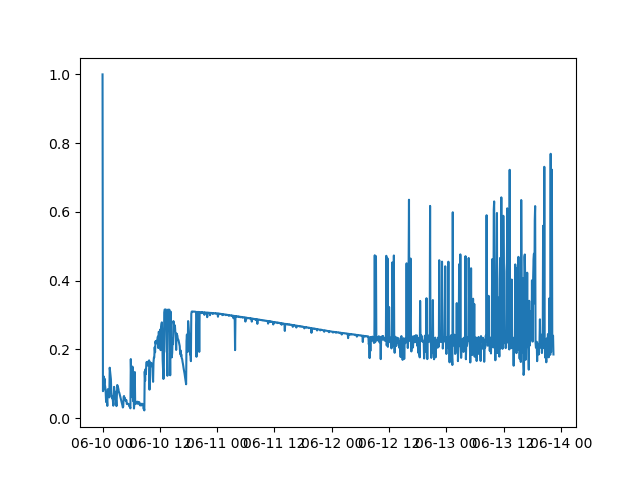

/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [15]:
plt.figure()
plt.plot(his_ds.time,his_ds.timestep)

<IPython.core.display.Javascript object>


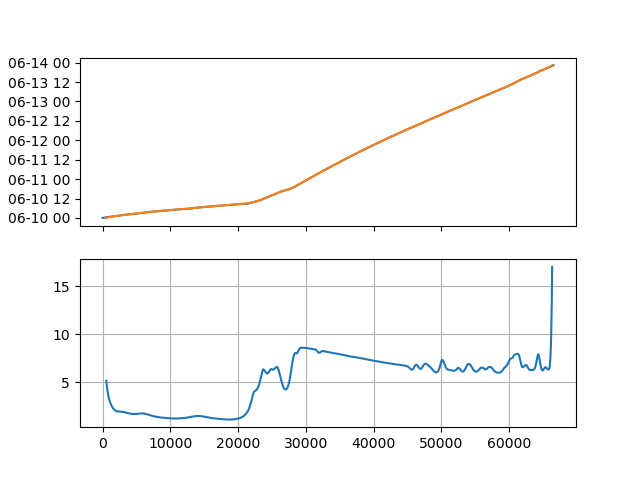

In [32]:
from stompy import filters
# I want to know if the slow overall speed of 5x realtime is because
# it was super slow at first, or because the whole run is slow.
# Make a synthetic wall clock time series

# assuming a constant time per timestep, plot roughly the simulation speedup

times=(his_ds.time.values - his_ds.time.values[0])/np.timedelta64(1_000_000,'us')
interval=np.diff(times) 

nsteps=np.r_[ 0, interval / his_ds.timestep.values[1:]]  
wall_time=np.cumsum(nsteps)

speedup=(times[-1]-times[0])/(wall_time[-1]-wall_time[0])
fac=speedup/5.11
wall_time*=fac

wall_time_s=filters.lowpass_fir(wall_time,winsize=30)

fig,axs=plt.subplots(2,1,sharex=True)
axs[0].plot(wall_time, his_ds.time)
axs[0].plot(wall_time_s, his_ds.time)

axs[1].plot(wall_time_s[1:], np.diff(his_ds.time)/np.timedelta64(1,'s')/np.diff(wall_time_s))

# I know the overall run so far has been 5.1x realtime.

In [29]:
fac

numpy.timedelta64(35523169,'ns')

In [23]:
wall_time

array([ 0., inf, inf, ..., inf, inf, inf])

In [16]:
his_ds

<xarray.Dataset>
Dimensions:                                  (cross_section: 10, gategens: 3, general_structures: 2, laydim: 28, laydimw: 29, nFlowElemContourPts: 4, nFlowElemWithBnd: 5705, nFlowLink: 8832, nFlowLinkPts: 2, nNetLink: 9154, nNetLinkPts: 2, station_geom_nNodes: 496, stations: 496, time: 1134)
Coordinates:
    station_x_coordinate                     (stations) float64 ...
    station_y_coordinate                     (stations) float64 ...
    station_name                             (stations) |S64 ...
    zcoordinate_c                            (time, stations, laydim) float64 ...
    zcoordinate_w                            (time, stations, laydimw) float64 ...
    zcoordinate_wu                           (time, stations, laydimw) float64 ...
    cross_section_name                       (cross_section) |S64 ...
    general_structure_id                     (general_structures) |S64 ...
    gategen_name                             (gategens) |S64 ...
  * time          